In [4]:
from utils import *
df = load_dataframe(path="../data/final_data_30_shards")
df = df.fillna(0.0)
print(df.shape)
print(df.columns)

(683254, 75)
Index(['Result', 'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination',
       'parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp',
       'ECO_white_accuracy_cp_mean', 'ECO_white_accuracy_cp_median',
       'ECO_white_accuracy_cp_std', 'ECO_black_accuracy_cp_mean',
       'ECO_black_accuracy_cp_median', 'ECO_black_accuracy_cp_std',
       'White_white_accuracy_cp_mean', 'White_white_accuracy_cp_median',
       'White_white_accuracy_cp_std', 'White_black_accuracy_cp_mean',
       'White_black_accuracy_cp_median', 'White_black_accuracy_cp_std',
       'total_full_moves', 'moves_before_castle_white',
       'moves_before_castle_black', 'legal_move_diff_at_25',
       'legal_move_diff_at_50', 'legal_move_diff_at_75',
       'legal_move_diff_at_100', 'development_before_white',
       'development_before_black', 'center_control_after_5_white',
       'unique_pieces_after_10_white', 'unique_pieces_after_10_black',
       'blunder_counts_white', 'blunder_counts_black'

## Data Preparation

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Define target variables (Y) for regression tasks
# We will predict White's Elo, Black's Elo, and the average of the two
y_reg_white = df['WhiteElo']
y_reg_black = df['BlackElo']
y_reg_avg = df[['WhiteElo', 'BlackElo']].mean(axis=1)

y_clf_avg = pd.qcut(y_reg_avg, q=10, labels=False, duplicates='drop')
eco_cols = [col for col in df.columns if 'ECO_' in col]
X_eco = df[eco_cols]


# Split for the baseline linear regression model (using only ECO features)
X_eco_train, X_eco_test, y_eco_train_white, y_eco_test_white = train_test_split(X_eco, y_reg_white, test_size=0.3, random_state=42)
_, _, y_eco_train_black, y_eco_test_black = train_test_split(X_eco, y_reg_black, test_size=0.3, random_state=42)
_, _, y_eco_train_avg, y_eco_test_avg = train_test_split(X_eco, y_reg_avg, test_size=0.3, random_state=42)


# Define the feature matrix (X) by dropping target variables and non-feature columns
categorical = df[['Termination', "ECO"]]
X = df.drop(columns=['WhiteElo', 'BlackElo', 'Result', 'Opening', 'Termination', "ECO"])

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)

# 2) One‑hot encode your categorical subset correctly:
categorical_OHE = pd.get_dummies(
    categorical,
    columns=['ECO', 'Termination'],
    drop_first=False
)
X_final = X_scaled.join(categorical_OHE)
X_train, X_test, y_train_clf, y_test_clf = train_test_split(X_final, y_clf_avg, test_size=0.3, random_state=42)

## Linear Regression

Simple linear regression on one-hot encoded openings

In [3]:
# Import necessary libraries for linear regression and model evaluation
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Define a helper function to evaluate and print regression metrics
def eval_regression(y_true, y_pred, model_name):
    print(f'--- {model_name} ---')
    # Root Mean Squared Error (RMSE) measures the average prediction error
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    # R-squared (R^2) score indicates the proportion of variance explained by the model
    print("R^2 score:", metrics.r2_score(y_true, y_pred))
    # Calculate accuracy within specific Elo point deviations (50, 100, 200)
    for dev in [50, 100, 200]:
        acc = np.mean(np.abs(y_true - y_pred) <= dev) * 100
        print(f'Accuracy (+/- {dev} Elo): {acc:.2f}%')

# Train three separate linear regression models: one for each target (White Elo, Black Elo, Average Elo)
lr_white = LinearRegression().fit(X_eco_train, y_eco_train_white)
lr_black = LinearRegression().fit(X_eco_train, y_eco_train_black)
lr_avg = LinearRegression().fit(X_eco_train, y_eco_train_avg)

# Evaluate each model on the test set and print the results
eval_regression(y_eco_test_white, lr_white.predict(X_eco_test), 'Linear Regression (White Elo)')
eval_regression(y_eco_test_black, lr_black.predict(X_eco_test), 'Linear Regression (Black Elo)')
eval_regression(y_eco_test_avg, lr_avg.predict(X_eco_test), 'Linear Regression (Average Elo)')

--- Linear Regression (White Elo) ---
RMSE: 369.5873630712254
R^2 score: 0.1305788639676968
Accuracy (+/- 50 Elo): 9.83%
Accuracy (+/- 100 Elo): 19.52%
Accuracy (+/- 200 Elo): 38.45%
--- Linear Regression (Black Elo) ---
RMSE: 369.2978730151072
R^2 score: 0.13165233670496412
Accuracy (+/- 50 Elo): 9.79%
Accuracy (+/- 100 Elo): 19.49%
Accuracy (+/- 200 Elo): 38.45%
--- Linear Regression (Average Elo) ---
RMSE: 363.25792366205445
R^2 score: 0.13495239682220705
Accuracy (+/- 50 Elo): 9.93%
Accuracy (+/- 100 Elo): 19.74%
Accuracy (+/- 200 Elo): 38.96%


White Elo in test: 400 → 3011
Black Elo in test: 400 → 2935
Average Elo in test: 400.0 → 2934.5


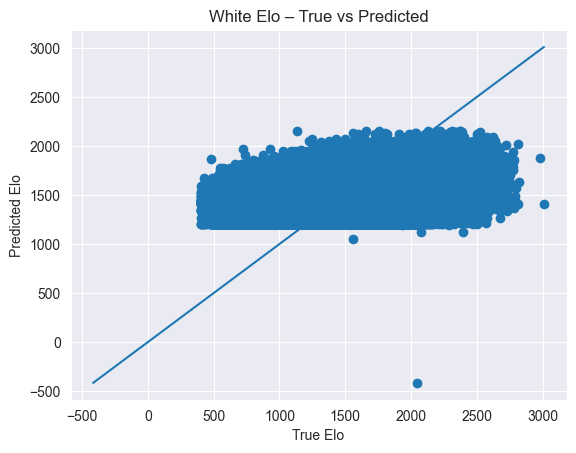

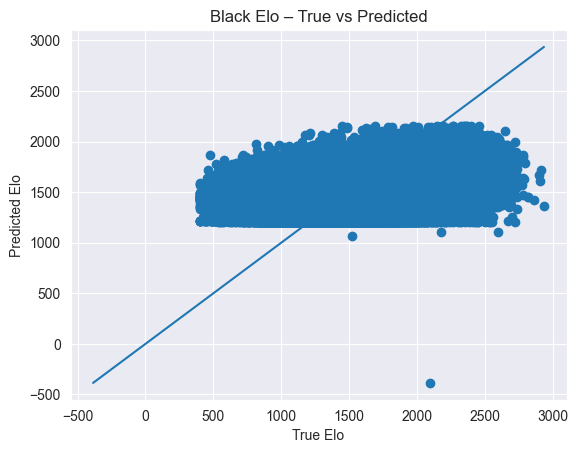

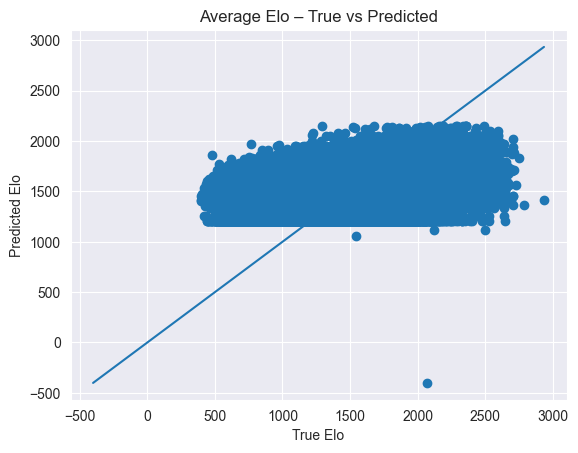

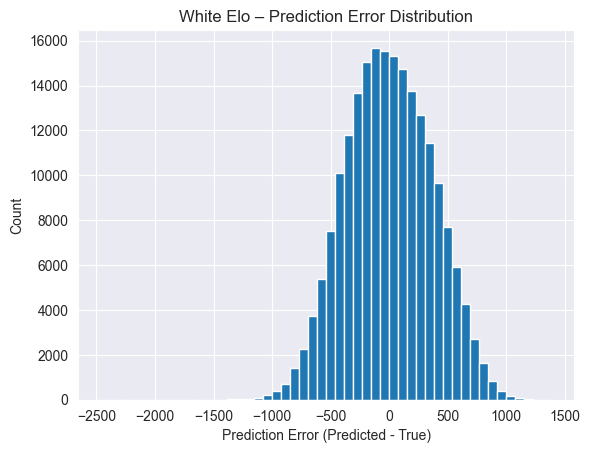

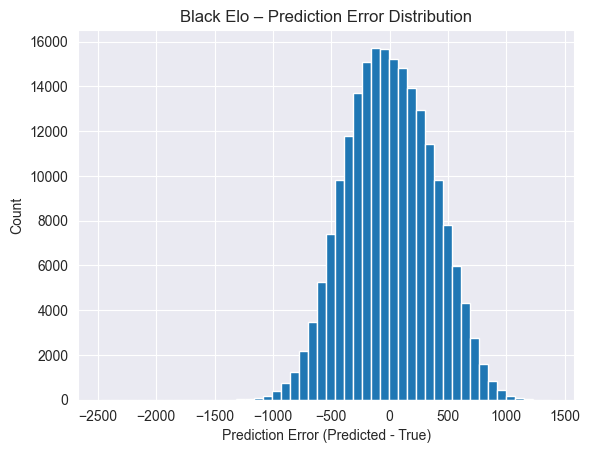

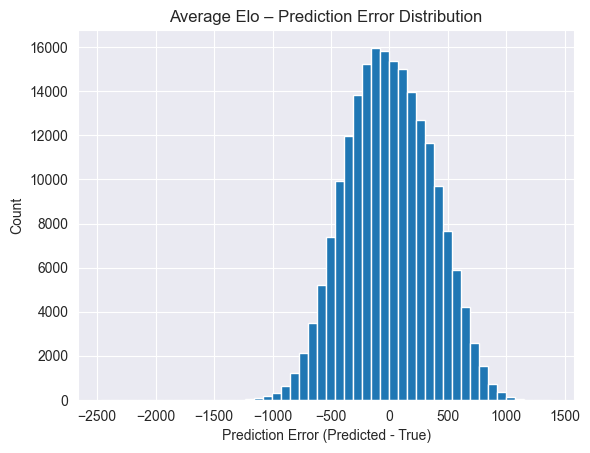

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

# Train models
lr_white = LinearRegression().fit(X_eco_train, y_eco_train_white)
lr_black = LinearRegression().fit(X_eco_train, y_eco_train_black)
lr_avg   = LinearRegression().fit(X_eco_train, y_eco_train_avg)

# Predict
preds = {
    'White Elo': (y_eco_test_white, lr_white.predict(X_eco_test)),
    'Black Elo': (y_eco_test_black, lr_black.predict(X_eco_test)),
    'Average Elo': (y_eco_test_avg,   lr_avg.predict(X_eco_test))
}

# Compute metrics and collect for display
records = []
for name, (y_true, y_pred) in preds.items():
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    r2   = metrics.r2_score(y_true, y_pred)
    records.append({'Model': name, 'Metric': 'RMSE', 'Value': rmse})
    records.append({'Model': name, 'Metric': 'R^2',  'Value': r2})
    for dev in [50, 100, 200]:
        acc = np.mean(np.abs(y_true - y_pred) <= dev) * 100
        records.append({'Model': name, 'Metric': f'Acc ±{dev}', 'Value': acc})

df_metrics = pd.DataFrame(records)
print("White Elo in test:", y_eco_test_white.min(), "→", y_eco_test_white.max())
print("Black Elo in test:", y_eco_test_black.min(), "→", y_eco_test_black.max())
print("Average Elo in test:", y_eco_test_avg.min(), "→", y_eco_test_avg.max())

# 1) Scatter plots: True vs Predicted
for name, (y_true, y_pred) in preds.items():
    plt.figure()
    plt.scatter(y_true, y_pred)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx])
    plt.title(f'{name} – True vs Predicted')
    plt.xlabel('True Elo')
    plt.ylabel('Predicted Elo')
    plt.show()

# 2) Error distribution histograms
for name, (y_true, y_pred) in preds.items():
    errors = y_pred - y_true
    plt.figure()
    plt.hist(errors, bins=50)
    plt.title(f'{name} – Prediction Error Distribution')
    plt.xlabel('Prediction Error (Predicted - True)')
    plt.ylabel('Count')
    plt.show()

## Bayesian Ridge Regression

--- Bayesian Ridge (Average Elo) ---
RMSE: 363.25780394896105
R^2 score: 0.13495296698186865
Accuracy (+/- 50 Elo): 9.93%
Accuracy (+/- 100 Elo): 19.74%
Accuracy (+/- 200 Elo): 38.96%


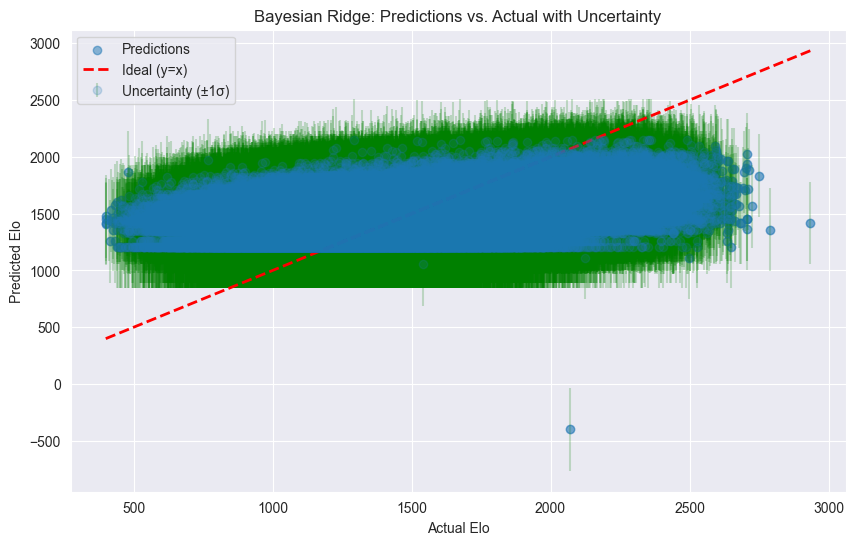


 Average predictive uncertainty (±1σ): 363.02 Elo

🔽 Minimum uncertainty prediction:
  Std: 362.98 Elo
  Actual Elo: 2140.50
  Predicted Elo: 2135.13

🔼 Maximum uncertainty prediction:
  Std: 364.73 Elo
  Actual Elo: 2069.50
  Predicted Elo: -398.08

📊 Uncertainty by Elo range:
Low Elo: 363.02 Elo (n=43687)
Mid Elo: 363.02 Elo (n=105354)
High Elo: 363.02 Elo (n=55936)


In [6]:
from sklearn.linear_model import BayesianRidge

# Convert once, up front, to a bona fide float64 ndarray
X_train_np = X_eco_train.values.astype(np.float64)
y_train_np = y_eco_train_avg.values.astype(np.float64)

X_test_np = X_eco_test.values.astype(np.float64)
y_test_np = y_eco_test_avg.values.astype(np.float64)

# Fit & predict
br = BayesianRidge()
br.fit(X_train_np, y_train_np)
y_pred_br, y_std_br = br.predict(X_test_np, return_std=True)

# --- Evaluate (your own function assumed) ---
eval_regression(y_test_np, y_pred_br, 'Bayesian Ridge (Average Elo)')

# --- Plot with uncertainty ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_br, alpha=0.5, label='Predictions')
plt.errorbar(
    y_test_np, y_pred_br,
    yerr=y_std_br, fmt='o', ecolor='g', alpha=0.2,
    label='Uncertainty (±1σ)'
)
ideal = [y_test_np.min(), y_test_np.max()]
plt.plot(ideal, ideal, 'r--', lw=2, label='Ideal (y=x)')
plt.xlabel('Actual Elo')
plt.ylabel('Predicted Elo')
plt.title('Bayesian Ridge: Predictions vs. Actual with Uncertainty')
plt.legend()
plt.show()

# ================================
# Compute Uncertainty Statistics
# ================================

# Average uncertainty (std) over all test points
mean_uncertainty = np.mean(y_std_br)
print(f"\n Average predictive uncertainty (±1σ): {mean_uncertainty:.2f} Elo")

# Define Elo bands (you can adjust these)
elo_bands = {
    'Low Elo': (0, 1200),
    'Mid Elo': (1200, 1800),
    'High Elo': (1800, np.inf)
}

min_uncertainty = np.min(y_std_br)
max_uncertainty = np.max(y_std_br)

min_idx = np.argmin(y_std_br)
max_idx = np.argmax(y_std_br)

print("\n🔽 Minimum uncertainty prediction:")
print(f"  Std: {min_uncertainty:.2f} Elo")
print(f"  Actual Elo: {y_test_np[min_idx]:.2f}")
print(f"  Predicted Elo: {y_pred_br[min_idx]:.2f}")

print("\n🔼 Maximum uncertainty prediction:")
print(f"  Std: {max_uncertainty:.2f} Elo")
print(f"  Actual Elo: {y_test_np[max_idx]:.2f}")
print(f"  Predicted Elo: {y_pred_br[max_idx]:.2f}")

# Compute and print average uncertainty for each band
print("\n📊 Uncertainty by Elo range:")
for label, (low, high) in elo_bands.items():
    mask = (y_test_np >= low) & (y_test_np < high)
    if np.sum(mask) == 0:
        print(f"{label}: No data")
        continue
    band_uncertainty = np.mean(y_std_br[mask])
    print(f"{label}: {band_uncertainty:.2f} Elo (n={np.sum(mask)})")
